# Environment Rollouts and Reward Shaping

This notebook goes through how to setup utilities for Reinforcement Learning, and also how to setup and interact with a discrete environment using TorchRL.

### Installing prerequisite libraries

We will experiment getting observations from the MountainCarV0 environment, using TorchRL and gymnasium



In [1]:
!pip install torchrl==0.7.0 gymnasium==0.29 tqdm matplotlib av tensordict==0.7.2
!mkdir working

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###Import relevant libraries

Next, we will import the VideoRecorder and environment-related libraries from TorchRL.

- Visualisation
 - `CSVLogger` to log the pixel observations
 - `VideoRecorder` to record the video based on the logs
- Loading environment
  - `check_env_specs`: Checks if environment was loaded correctly
  - `GymWrapper`: Makes TorchRL compatible with gym, which is a library for creating and loading environments
  - `TransformedEnv`,`Compose`: These help us transform our env, and is similar to data augmentation in other fields. We can compose a list of transformation to help normalise, scale or even track the total number of steps
    - `DoubleToFloat`: Maps float64 values to float32, which improves training efficiency

The rest of the imports will just be used for testing the environment in this unit, and the relevant implementations will be hidden for now. We will review these modules in the next unit, when we buid an end-to-end reinforcement learning model.


#NOTE:
If you get a `ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject`

That is perfectly fine, just restart the runtime and rerun it, and the error will disappear.


In [1]:
# It's ok if this cell runs for a while, it takes time for the modules to load.

import torch
from collections import defaultdict
import numpy as np
import gymnasium as gym
from pathlib import Path
from IPython.display import Video, display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Import TorchRL components
from torch.distributions import Categorical
from torchrl.envs import TransformedEnv,Compose, GymWrapper, RewardScaling, StepCounter, DoubleToFloat
from torchrl.record import VideoRecorder
from torchrl.record.loggers.csv import CSVLogger
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tensordict.nn import TensorDictModule
from torchrl.modules import ProbabilisticActor, ValueOperator, TanhNormal
from torchrl.envs.transforms import Transform
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type

### Setting up output directories
- This will make the code neater
- The seeds are for reproducibility

In [2]:
# 1. Set up directories and constants
OUTPUT_DIR = Path("./working/mountain_car_output")
OUTPUT_DIR.mkdir(exist_ok=True)
VIDEO_DIR = OUTPUT_DIR / "my_exp" / "videos"
#VIDEO_DIR will be automatically created by CSVLogger, so no need to mkdir
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)



### Loading the environment
A fundamental skill in RL is knowing how to load and transform your environment. We will go into detail on how to transform our environment to make training easier and set up necessary utilities.

1. First, we make the environment using `gym.make`. Since MountainCarV0 is already part of gym, we can use `gym.make` directly. We use `rgb_array` so that our logger and recorder can render the video later.

2. We then set up a `CSVLogger` which logs values in CSV format, and attach a `VideoRecorder` to it. The
`VideoRecorder` will take in logged values from the logger to render the video

3. We then use Compose, which lets us compose a list of transformations on our environment. We use `DoubleToFloat` to turn all float64 values into single precison numbers for faster training, and `StepCounter` is used to count the number of steps before termination

4. Lastly, we put our env and the transforms in the TransformedEnv function to create our new environment with the transforms.

In [3]:
def make_env():
    # Create the base environment
    base_env = gym.make("MountainCar-v0", render_mode="rgb_array")

    # Wrap with TorchRL's GymWrapper
    env = GymWrapper(base_env, device="cpu", from_pixels = True, pixels_only=  False)
    logger = CSVLogger(exp_name="my_exp", log_dir = OUTPUT_DIR, video_format="mp4")
    recorder =  VideoRecorder(logger, tag="my_video", skip=5)

    # Add transformations including video recording and reward shaping
    transforms = Compose(
        DoubleToFloat(),
        # Record video
        recorder,
        #Track steps in episode
        StepCounter(),
    )
    return TransformedEnv(env, transforms)


### Checking Environment
- It is essential that you check that the environment works after creating it. To do this, we will check whether the env specs are well defined using check_env_specs, and print out our observation, reward and action specs.

- These tell us what observation the environment returns, our possible actions and the possible rewards. In turn, this helps define the constraints based on the environment, and allow us to use a suitable policy or transform the data to better suit our needs.

For example, we can see that the input spec and action spec are discrete, which mean the environment can only take a defined set of values (accelerate left,acclerate right, don't accelerate) instead of a continuous value.

In [4]:
# Create the environment
env = make_env()

# 4. Print information about action and observation spaces
check_env_specs(env)

print("Observation Spec:", env.observation_spec)
print()
print("Reward Spec:", env.reward_spec)
print()
print("Input Spec:", env.input_spec)
print()
print("Action Spec (as defined by Input Spec):", env.action_spec)


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Observation Spec: Composite(
    observation: BoundedContinuous(
        shape=torch.Size([2]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    pixels: UnboundedDiscrete(
        shape=torch.Size([400, 600, 3]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([400, 600, 3]), device=cpu, dtype=torch.uint8, contiguous=True),
            high=Tensor(shape=torch.Size([400, 600, 3]), device=cpu, dtype=torch.uint8, contiguous=True)),
        device=cpu,
        dtype=torch.uint8,
        domain=discrete),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shap

### Rollout
Next, to test whether the environment works and to test our policy, we will rollout the environment for 3000 steps (~ 3 seconds)

A rollout is a execution of a policy from its current state. `env.rollout(3000)` uses a random policy to randonly execute actions for 3000 steps.

`env.transform.dump` runs the `dump` operation on all our transforms, leading to a no-op, except for the VideoRecorder transform, where it will dump the video into our video dir.

In [5]:
rollout = env.rollout(3000)
print("Rollout of 3000 steps:",rollout)
print("Shape of rollout TensorDict", rollout.batch_size)

env.transform.dump()

Rollout of 3000 steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([200, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.Size([200, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(sha

### Visualise actions taken

In [6]:
#Render the video
Video(str(VIDEO_DIR / "my_video_0.mp4"), embed=True)

# Reward Shaping

We should intuitively observe from the video that the optimal strategy to win MountainCarV0 is to repeatedly move left and right until we reach the flag

The issue with RL models is that unlike us, they do not have an intuition or high level reasoning ability to find an optimal way to play the game. It just optimizes based on the rewards given.

This might lead to undesirable behaviours as it finds weird ways to maximise the rewards, without trying to win the game in its intended manner. We call this `Reward Hacking`.

Thus, it is imperative that we shape our rewards such that it leads to desirable outcomes.

In [7]:
# Create a new transform to shape the reward


# Define the custom reward transformation
class VelocityPositionReward(Transform):
    def __init__(self, velocity_weight=1.0, position_weight=1.0):
        super().__init__()
        self.velocity_weight = velocity_weight
        self.position_weight = position_weight

    def _call(self, tensordict):
        # Extract position and velocity from the observation
        position = tensordict["observation"][..., 0]
        velocity = tensordict["observation"][..., 1]

        # Compute the custom reward
        reward = self.velocity_weight * velocity + self.position_weight * position

        # Update the reward in the tensordict
        tensordict.set("reward", reward.unsqueeze(-1))
        return tensordict

def make_better_env():
    base_env = gym.make("MountainCar-v0", render_mode="rgb_array")

    # Wrap with TorchRL's GymWrapper
    env = GymWrapper(base_env, device="cpu", from_pixels = True, pixels_only=  False)
    logger = CSVLogger(exp_name="my_exp", log_dir = OUTPUT_DIR, video_format="mp4")
    recorder =  VideoRecorder(logger, tag="my_video")

    # Add transformations including video recording and reward shaping
    transforms = Compose(
        # Record video
        DoubleToFloat(),
        VelocityPositionReward(),
        #Track steps in episode
        StepCounter(),
    )
    return TransformedEnv(env, transforms)


### We check the env specs again to check if the env was loaded properly

In [8]:
better_env = make_better_env()

print(check_env_specs(better_env))
print("Reward Spec:",better_env.reward_spec)
print("Observation Spec:",better_env.observation_spec)
print("Input Spec:", better_env.input_spec)
print("Action Spec (as defined by Input Spec):", better_env.action_spec)

2025-05-06 03:20:23,167 [torchrl][INFO] check_env_specs succeeded!


None
Reward Spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)
Observation Spec: Composite(
    observation: BoundedContinuous(
        shape=torch.Size([2]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    pixels: UnboundedDiscrete(
        shape=torch.Size([400, 600, 3]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([400, 600, 3]), device=cpu, dtype=torch.uint8, contiguous=True),
            high=Tensor(shape=torch.Size([400, 600, 3

### Testing the environment further
One way to test the environment is to also train a simple policy for a few steps, and letting it run. This allows us to get a feel for what transforms and reward shaping we need to train a good policy. For now, the code will be abstracted away and hidden, but you may run this to view the results.

In [17]:
# Optimization Hyperparameters

num_cells = 64  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

# Collection Hyperparams
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000

# Algorithm Hyperparameters
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Simple Actor-Critic Setup

# You can skip these if you want, these are the underlying neural networks.
# Since we are using a Discrete policy, we need to use a Softmax to transform the outputs into action probabilities.
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(better_env.action_spec.shape[-1], device = DEVICE),
    nn.Softmax()
)

value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=DEVICE),
    nn.Tanh(),
    nn.LazyLinear(1, device=DEVICE),
)


# Actor Module
policy_module = ProbabilisticActor(
    module = TensorDictModule(
        actor_net, in_keys=["observation"], out_keys=["logits"]
    ),
    spec=better_env.action_spec,
    in_keys=["logits"],
    distribution_class=Categorical,
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

# Critic Module
value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

/usr/local/lib/python3.11/dist-packages/tensordict/nn/probabilistic.py:460: DeprecationWarning: You are querying the log-probability key of a SafeProbabilisticModule where the composite_lp_aggregate has not been set and the log-prob key has not been chosen. Currently, it is assumed that composite_lp_aggregate() will return True: the log-probs will be aggregated in a sample_log_prob entry. From v0.9, this behaviour will be changed and individual log-probs will be written in `('path', 'to', 'leaf', '<sample_name>_log_prob')`. To prepare for this change, call `set_composite_lp_aggregate(mode: bool).set()` at the beginning of your script (or set the COMPOSITE_LP_AGGREGATE env variable). Use mode=True to keep the current behaviour, and mode=False to use per-leaf log-probs.
  warnings.warn(


In [19]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

collector = SyncDataCollector(
    better_env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=DEVICE,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [20]:
import torch

# Assuming that your environment is already created and wrapped in `composed_env`
# and that it provides observations of a particular shape.
# You might need to adjust this depending on your actual observation space.
# For example, if your observation has shape (n,), do:
print(env.observation_spec.shape)
print(better_env.observation_spec.shape)

dummy_td = better_env.reset()
dummy_observation = dummy_td["observation"].unsqueeze(0)
# Run a dummy forward pass through the actor network
# If your actor network expects the observation in a dict form, wrap it accordingly.
_ = actor_net(dummy_observation)

# Similarly, run a dummy forward pass through the value (critic) network
_ = value_net(dummy_observation)


torch.Size([])
torch.Size([])


In [21]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True, device=DEVICE,
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)


In [22]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(DEVICE))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = better_env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


  0%|          | 0/50000 [00:00<?, ?it/s]

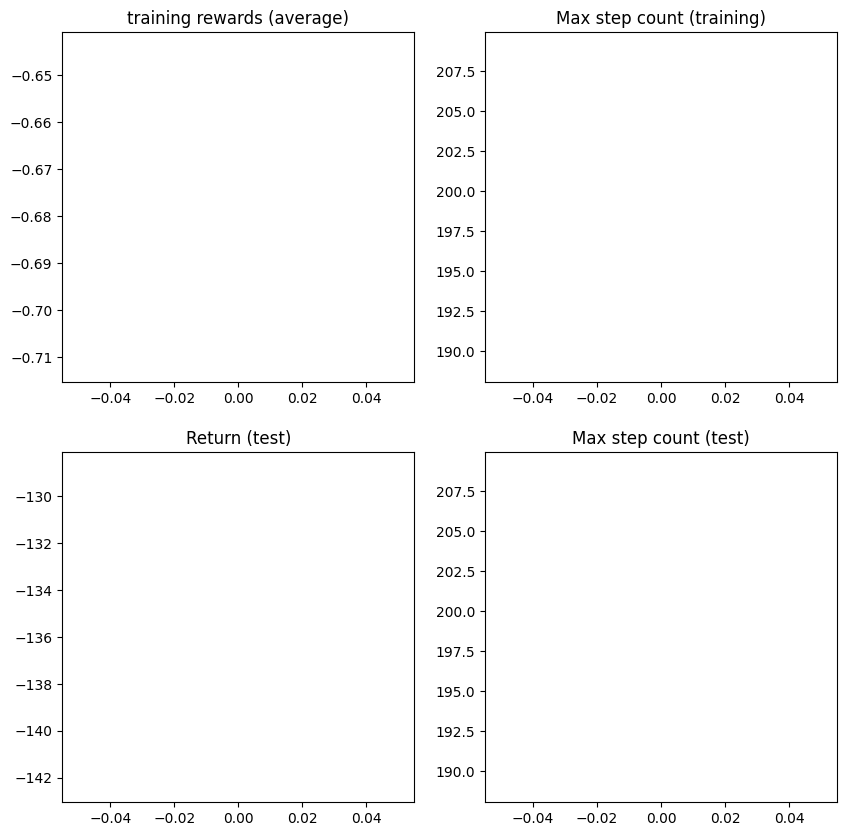

In [15]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [16]:
with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
    # execute a rollout with the trained policy
    eval_rollout = env.rollout(1000, policy_module)
    print(eval_rollout)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([200]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                pixels: Tensor(shape=torch.Size([200, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([200, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([200, 1]), device=cp

### Further Resources:

Try solving this with another library ([StableBaselines3](https://stable-baselines3.readthedocs.io/en/master/), [tianshou](https://tianshou.org/en/stable/))

Try looking at different environments and how their specs differ - You might come across discrete vs continuous environments. Take your time to note the differences between both types of environments.

